In [11]:
from torchvision.transforms.functional import to_tensor
from ultralytics import YOLO
from PIL import Image
import torch

from transformation import detect_objects, draw_boxes, apply_patch_to_image

# Patch image and prediction on the original image

---

In [12]:
# Load the original image
image_path = "original_images/img1.jpg"
original_image = Image.open(image_path)
original_size = original_image.size

patch_image_path = "patches/visdrone_p.png"
patch = Image.open(patch_image_path)

yolo_model = YOLO("yolov8n.pt")

TARGET_CLASS = 'car'
SIZE_MULTIPLE = 0.5

In [13]:
# Step 1: Detect objects
detection_results, resized_size = detect_objects(original_image, yolo_model)


0: 448x640 4 cars, 2 cell phones, 1 clock, 32.5ms
Speed: 2.0ms preprocess, 32.5ms inference, 5.0ms postprocess per image at shape (1, 3, 448, 640)


In [14]:
# Step 2: Draw boxes on the original image
image_with_boxes = draw_boxes(original_image.copy(), detection_results, resized_size, TARGET_CLASS)
# Convert the loaded patch image to a tensor before applying
patch_tensor = to_tensor(patch)

In [15]:
# Step 4: Apply the patch to the image
patched_image = apply_patch_to_image(original_image.copy(), patch_tensor, detection_results, resized_size, TARGET_CLASS, size_multiple=SIZE_MULTIPLE)

In [16]:
# Display or save the results
image_with_boxes.save("image_with_boxes.jpg")
# patched_image.save("patched_image.jpg")

# Optionally display the images
# image_with_boxes.show()
# patched_image.show()

# Predict on the patched image to test the patch

---

In [17]:
# Step 5: Detect objects in the patched image
patched_detection_results, _ = detect_objects(patched_image, yolo_model)

# Step 6: Draw boxes on the patched image based on the new detections
patched_image_with_boxes = draw_boxes(patched_image.copy(), patched_detection_results, resized_size, TARGET_CLASS)

# Save or display the patched image with new detection boxes
patched_image_with_boxes.save("patched_image_with_boxes.jpg")
# patched_image_with_boxes.show()

0: 448x640 8 persons, 2 cars, 1 surfboard, 1 cell phone, 1 clock, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)


In [18]:
# Print detection results for the original image
print("Detection Results on Original Image:")
for i, bbox in enumerate(detection_results.boxes.xyxy):
    class_id = detection_results.boxes.cls[i]
    class_name = detection_results.names[class_id.item() if isinstance(class_id, torch.Tensor) else class_id]
    conf = detection_results.boxes.conf[i]
    print(f"Class: {class_name}, Confidence: {conf:.2f}, Box: {bbox.tolist()}")

# Print detection results for the patched image
print("\nDetection Results on Patched Image:")
for i, bbox in enumerate(patched_detection_results.boxes.xyxy):
    class_id = patched_detection_results.boxes.cls[i]
    class_name = patched_detection_results.names[class_id.item() if isinstance(class_id, torch.Tensor) else class_id]
    conf = patched_detection_results.boxes.conf[i]
    print(f"Class: {class_name}, Confidence: {conf:.2f}, Box: {bbox.tolist()}")


Detection Results on Original Image:
Class: car, Confidence: 0.74, Box: [301.2047424316406, 303.85638427734375, 385.3539733886719, 365.49517822265625]
Class: car, Confidence: 0.72, Box: [335.17498779296875, 75.4029541015625, 407.24212646484375, 148.60089111328125]
Class: cell phone, Confidence: 0.69, Box: [114.86508178710938, 0.034759521484375, 172.55728149414062, 55.29334259033203]
Class: clock, Confidence: 0.59, Box: [0.060443878173828125, 0.4720878601074219, 45.56650161743164, 127.67945861816406]
Class: car, Confidence: 0.51, Box: [501.49664306640625, 374.9217834472656, 578.2030639648438, 432.3019104003906]
Class: car, Confidence: 0.41, Box: [181.19265747070312, 164.45846557617188, 266.11279296875, 214.94375610351562]
Class: cell phone, Confidence: 0.30, Box: [180.94381713867188, 164.5806427001953, 265.6360778808594, 215.4472198486328]

Detection Results on Patched Image:
Class: person, Confidence: 0.59, Box: [208.4271697998047, 168.77976989746094, 225.0011444091797, 197.78944396972

In [19]:
# Collect confidence scores for the target class 'car' from both original and patched images
original_confidences = [detection_results.boxes.conf[i].item() for i in range(len(detection_results.boxes.xyxy))
                        if detection_results.names[detection_results.boxes.cls[i].item()] == TARGET_CLASS]

patched_confidences = [patched_detection_results.boxes.conf[i].item() for i in range(len(patched_detection_results.boxes.xyxy))
                       if patched_detection_results.names[patched_detection_results.boxes.cls[i].item()] == TARGET_CLASS]

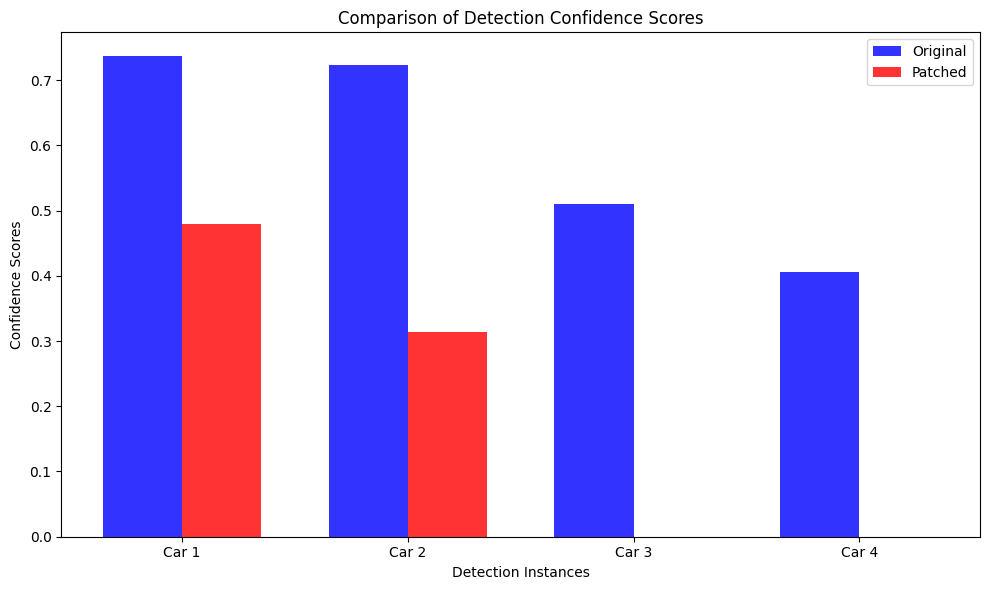

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming equal or less number of detections on patched image, pad the shorter list for equal length
max_len = max(len(original_confidences), len(patched_confidences))
original_confidences += [0] * (max_len - len(original_confidences))  # Pad with zeros
patched_confidences += [0] * (max_len - len(patched_confidences))  # Pad with zeros

# Generate indices for each pair of confidence scores
indices = np.arange(max_len)

# Create the bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
opacity = 0.8

bar1 = plt.bar(indices, original_confidences, bar_width, alpha=opacity, color='b', label='Original')
bar2 = plt.bar(indices + bar_width, patched_confidences, bar_width, alpha=opacity, color='r', label='Patched')

plt.xlabel('Detection Instances')
plt.ylabel('Confidence Scores')
plt.title('Comparison of Detection Confidence Scores')
plt.xticks(indices + bar_width / 2, [f'Car {i+1}' for i in indices])
plt.legend()

plt.tight_layout()
plt.show()
